# Lauren Bassett 
# jme9rt 
# DS5001 Final Project  

*The goal of your final project is to apply and integrate what you have learned in this course to
create ​a digital critical edition of a corpus​ that will support exploration of the cultural contents of
that corpus. Cultural content is broadly conceived​—it may be about language use, social events,
cultural categories, sentiments, identity, taste, etc.*

# Part 0: Import Statements/Reading in Files

In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import re
from glob import glob
import re
import nltk
from scipy.linalg import eigh, norm
import plotly_express as px
from sklearn.decomposition import PCA
import seaborn as sns
from gensim.models import word2vec
from sklearn.manifold import TSNE
from tqdm import tqdm
import re
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
epub_dir = 'books'


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laure\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part 1: Convert

In [2]:
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
chaps = "First|Second|Third|Fourth|Fifth|Sixth"
chap_pats = {
345: {
    'start_line': 22,
    'end_line': 15419,
    'chapter': re.compile('^\s*CHAPTER\s+{}.\s*$'.format(roman))
    },
174: {
    'start_line': 21,
    'end_line': 8554,
    'chapter': re.compile('^\s*CHAPTER\s+{}.\s*$'.format(roman))
    },
175: {
    'start_line': 18,
    'end_line': 10454,
    'chapter': re.compile('^\s*Chapter\s+{}.*$'.format(roman))
}
    }


In [3]:
def acquire_epubs(epub_list, chap_pats, OHCO=OHCO):
    
    my_lib = []
    my_doc = []

    for epub_file in epub_list:
        
        # Get PG ID from filename
        book_id = int(epub_file.split('-')[-1].split('.')[0].replace('pg',''))
        print("BOOK ID", book_id)
        
        # Import file as lines
        lines = open(epub_file, 'r', encoding='utf-8-sig').readlines()
        df = pd.DataFrame(lines, columns=['line_str'])
        df.index.name = 'line_num'
        df.line_str = df.line_str.str.strip()
        df['book_id'] = book_id
        
        # FIX CHARACTERS TO IMPROVE TOKENIZATION
        df.line_str = df.line_str.str.replace('—', ' — ')
        df.line_str = df.line_str.str.replace('-', ' - ')
        
        # Get book title and put into LIB table -- note problems, though
        book_title = re.sub(r"The Project Gutenberg eBook( of|,) ", "", df.loc[0].line_str, flags=re.IGNORECASE)
        book_title = re.sub(r"Project Gutenberg's ", "", book_title, flags=re.IGNORECASE)
        title, author = book_title.split(', by')


        # Remove cruft
        a = chap_pats[book_id]['start_line'] - 1
        b = chap_pats[book_id]['end_line'] + 1
        df = df.iloc[a:b]
        
        # Chunk by chapter
        chap_lines = df.line_str.str.match(chap_pats[book_id]['chapter'])
        chap_nums = [i+1 for i in range(df.loc[chap_lines].shape[0])]
        df.loc[chap_lines, 'chap_num'] = chap_nums
        df.chap_num = df.chap_num.ffill()

        # Clean up
        df = df[~df.chap_num.isna()] # Remove chapter heading lines
        df = df.loc[~chap_lines] # Remove everything before Chapter 1
        df['chap_num'] = df['chap_num'].astype('int')
        
        # Group -- Note that we exclude the book level in the OHCO at this point
        df = df.groupby(OHCO[1:2]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
        
        # Split into paragrpahs
        df = df['line_str'].str.split(r'\n\n+', expand=True).stack().to_frame().rename(columns={0:'para_str'})
        df.index.names = OHCO[1:3] # MAY NOT BE NECESSARY UNTIL THE END
        df['para_str'] = df['para_str'].astype(str).replace(r'\n', ' ').str.strip()
        df = df[~df['para_str'].str.match(r'^\s*$')] # Remove empty paragraphs
       
      
        # Set index
        df['book_id'] = book_id
        df = df.reset_index().set_index(OHCO[:3])

        # Register
        my_lib.append((book_id,title, author, epub_file))
        my_doc.append(df)

    docs = pd.concat(my_doc)
    library = pd.DataFrame(my_lib, columns=['book_id', 'book_title','author','book_file']).set_index('book_id')
    print("Done.")
    return library, docs

In [4]:
epubs = [epub for epub in sorted(glob(epub_dir+'/*.txt'))]
LIB, DOC = acquire_epubs(epubs, chap_pats)

BOOK ID 174
BOOK ID 175
BOOK ID 345
Done.


In [5]:
epubs = [epub for epub in sorted(glob(epub_dir+'/*.txt'))]
LIB, DOC = acquire_epubs(epubs, chap_pats)

BOOK ID 174
BOOK ID 175
BOOK ID 345
Done.


In [6]:
DOC.sample(10)

para_str
book_id chap_num para_num                                                   
345     18       36        "They never leave me; and they shall not till ...
        20       74        "Then there is not a moment to lose: it may no...
174     2        112       “Is it the real Dorian?” cried the original of...
175     19       56        A man entered, also wearing an astrakhan cap a...
345     18       40        "May it not frighten her terribly? It is unusu...
175     19       28        "It is quite possible, Sir, if he is not, at t...
345     13       52        The reaction of the terrible strain came as he...
        19       9         "You would not kill yourself?" he asked, hoars...
175     13       61        And she left him hurriedly, still wringing and...
345     11       102       "That is good image," he said. "Well, I shall ...

In [7]:
dfs = DOC['para_str'].str.split(r'[.?!;:"]+', expand=True).stack()\
    .to_frame().rename(columns={0:'sent_str'})

dfs.index.names = OHCO[:4]

dfs = dfs[~dfs['sent_str'].str.match(r'^\s*$')] # Remove empty paragraphs

In [8]:
dft = dfs['sent_str'].str.split(r"[\s',-]+", expand=True).stack()\
    .to_frame().rename(columns={0:'token_str'})
    
dft.index.names = OHCO[:5]
dft

token_str
book_id chap_num para_num sent_num token_num          
174     1        1        0        0               The
                                   1            studio
                                   2               was
                                   3            filled
                                   4              with
...                                                ...
345     24       78       5        17              for
                                   18              her
                                   19             sake
                 79       0        0          JONATHAN
                                   1            HARKER

[345936 rows x 1 columns]

# Part 2: Annotate

In [9]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [10]:
TOKEN = tokenize(DOC, ws=False)

In [11]:
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')


C:\Users\laure\AppData\Local\Temp/ipykernel_28828/2045287459.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')


In [12]:
VOCAB = TOKEN.term_str.value_counts().to_frame()\
    .rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [13]:
VOCAB['stop'] = VOCAB.term_str.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
VOCAB[VOCAB.stop == 1].sample(10)


term_str     n  num  stop
term_id                          
113        above    53    0     1
8085        most   192    0     1
5860        have  2007    0     1
12591       them   853    0     1
1186       being   175    0     1
5863      having    78    0     1
6773          it  4315    0     1
12602      there  1379    0     1
3781        down   464    0     1
5833         has   614    0     1

In [14]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.term_str.apply(stemmer1.stem)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.term_str.apply(stemmer2.stem)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.term_str.apply(stemmer3.stem)

In [15]:
def get_POS_Count(row):
    term = row['term_str']

    return TOKEN[TOKEN['term_str']== term].value_counts('pos').idxmax() 


In [16]:
VOCAB['pos_max'] = VOCAB.apply(get_POS_Count, axis=1)

In [17]:
VOCAB.sample(10)

term_str    n  num  stop stem_porter stem_snowball stem_lancaster  \
term_id                                                                      
7677      martyrs    1    0     0      martyr        martyr         martyr   
13887      widens    1    0     0       widen         widen            wid   
10583       round  222    0     0       round         round          round   
14071      wretch    7    0     0      wretch        wretch         wretch   
13350          up  768    0     1          up            up             up   
11599        soon  141    0     0        soon          soon           soon   
1740       butler    4    0     0      butler        butler           butl   
4824        finis    2    0     0        fini          fini            fin   
12247    superbly    1    0     0     superbl       superbl        superbl   
8866         part  114    0     0        part          part           part   

        pos_max  
term_id          
7677        NNS  
13887       VBZ  
10583        NN  
14071        NN  
13350        RP  
11599        RB  
1740         NN  
4824         NN  
12247        RB  
8866         NN

In [18]:
if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

Alternate Rank for  Groups of words by term count

In [19]:
new_rank = VOCAB.n.value_counts()\
    .sort_index(ascending=False).reset_index().reset_index()\
    .rename(columns={'level_0':'term_rank2', 'index':'n', 'n':'nn'})\
    .set_index('n')
VOCAB['term_rank2'] = VOCAB.n.map(new_rank.term_rank2) + 1
VOCAB.head()

term_rank term_str      n  num  stop stem_porter stem_snowball  \
term_id                                                                   
0                1           64142    0     0                             
12580            2      the  16749    0     1         the           the   
519              3      and  10336    0     1         and           and   
12780            4       to   8988    0     1          to            to   
6252             5        i   7885    0     1           i             i   

        stem_lancaster pos_max  term_rank2  
term_id                                     
0                            ,           1  
12580              the      DT           2  
519                and      CC           3  
12780               to      TO           4  
6252                 i     PRP           5

### Computing Zipf's K

In [20]:
VOCAB['p'] = VOCAB.n / VOCAB.shape[0]
VOCAB['zipf_k'] = VOCAB.n * VOCAB.term_rank
VOCAB['zipf_k2'] = VOCAB.n * VOCAB.term_rank2
VOCAB['zipf_k3'] = VOCAB.p * VOCAB.term_rank2

In [21]:
VOCAB.describe().T


count          mean          std          min           25%  \
term_rank   14171.0   7086.000000  4090.959667     1.000000   3543.500000   
n           14171.0     27.233787   595.505777     1.000000      1.000000   
num         14171.0      0.005786     0.075851     0.000000      0.000000   
stop        14171.0      0.010514     0.102003     0.000000      0.000000   
term_rank2  14171.0    351.530097    36.524933     1.000000    357.000000   
p           14171.0      0.001922     0.042023     0.000071      0.000071   
zipf_k      14171.0  16976.539623  7667.127066  8192.000000  11734.500000   
zipf_k2     14171.0   3011.964152  6911.166952   362.000000    362.000000   
zipf_k3     14171.0      0.212544     0.487698     0.025545      0.025545   

                     50%           75%           max  
term_rank    7086.000000  10628.500000  14171.000000  
n               2.000000      6.000000  64142.000000  
num             0.000000      0.000000      1.000000  
stop            0.000000      0.000000      1.000000  
term_rank2    361.000000    362.000000    362.000000  
p               0.000141      0.000423      4.526286  
zipf_k      14294.000000  20212.000000  64142.000000  
zipf_k2       722.000000   2142.000000  64142.000000  
zipf_k3         0.050949      0.151154      4.526286

In [22]:
px.histogram(VOCAB, 'zipf_k', marginal='box',title= "Zipf's K")

In [23]:
px.histogram(VOCAB, 'zipf_k2', marginal='box', title="Zipf's K2")

In [24]:
px.histogram(VOCAB, 'zipf_k3', marginal='box', title="Zipf's K3")

In [25]:
TOKEN

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                   
174     1        1        0        0                (The, DT)   DT       The   
                                   1             (studio, NN)   NN    studio   
                                   2               (was, VBD)  VBD       was   
                                   3            (filled, VBN)  VBN    filled   
                                   4               (with, IN)   IN      with   
...                                                       ...  ...       ...   
345     24       78       2        29                  (., .)    .         .   
                                   30                ('', '')   ''        ''   
                 79       0        0          (JONATHAN, NNP)  NNP  JONATHAN   
                                   1            (HARKER, NNP)  NNP    HARKER   
                                   2                   (., .)    .         .   

                                              term_str  
book_id chap_num para_num sent_num token_num            
174     1        1        0        0               the  
                                   1            studio  
                                   2               was  
                                   3            filled  
                                   4              with  
...                                                ...  
345     24       78       2        29                   
                                   30                   
                 79       0        0          jonathan  
                                   1            harker  
                                   2                    

[385930 rows x 4 columns]

# Part 3: Create

In [26]:
count_method = 'n' # 'c' or 'n' # n = n tokens, c = distinct token (term) count
tf_method = 'sum' # sum, max, log, double_norm, raw, binary
tf_norm_k = .5 # only used for double_norm
idf_method = 'standard' # standard, max, smooth
gradient_cmap = 'YlGnBu' # YlGn, GnBu, YlGnBu; For tables; see https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html 

In [27]:
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
BOOKS = OHCO[:1]

In [28]:
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)

In [29]:
TOKEN.head()

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                 
174     1        1        0        0              (The, DT)   DT       The   
                                   1           (studio, NN)   NN    studio   
                                   2             (was, VBD)  VBD       was   
                                   3          (filled, VBN)  VBN    filled   
                                   4             (with, IN)   IN      with   

                                             term_str  term_id  
book_id chap_num para_num sent_num token_num                    
174     1        1        0        0              the    12580  
                                   1           studio    12101  
                                   2              was    13693  
                                   3           filled     4804  
                                   4             with    13962

In [30]:
VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos']).pos.count().unstack().idxmax(1)

In [31]:
VOCAB.sample(5)

term_rank   term_str    n  num  stop stem_porter stem_snowball  \
term_id                                                                   
13372           64         us  714    0     0          us            us   
3046          2579    customs    9    0     0      custom        custom   
6             2921         11    7    1     0          11            11   
14029         8685  workshops    1    0     0    workshop      workshop   
1563          7708   breathes    2    0     0      breath        breath   

        stem_lancaster pos_max  term_rank2         p  zipf_k  zipf_k2  \
term_id                                                                 
13372               us     PRP          64  0.050385   45696    45696   
3046            custom     NNS         354  0.000635   23211     3186   
6                   11      JJ         356  0.000494   20447     2492   
14029         workshop     NNS         362  0.000071    8685      362   
1563            breath     NNS         361  0.000141   15416      722   

          zipf_k3  
term_id            
13372    3.224614  
3046     0.224825  
6        0.175852  
14029    0.025545  
1563     0.050949

### POS Tag Distribution

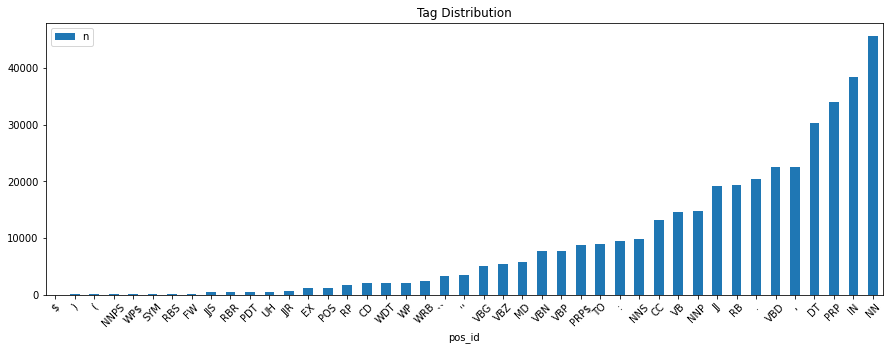

In [32]:
POS = TOKEN.pos.value_counts().to_frame().rename(columns={'pos':'n'})
POS.index.name = 'pos_id'
POS.sort_values('n').plot.bar(y='n', figsize=(15,5), rot=45, title="Tag Distribution");

In [33]:
def tfidif_matrix(df, bag, count, tf_method, idf_method):
    '''
    Write a function that returns a TFIDF matrix, with the following arguments:
    df - The tokens data frame to use.
    bag - The OHCO level to use, e.g. which "bag" to use.
    count - The type of count to use (e.g. binary counts are regular counts).
    tf_method - The type of TF to use.
    idf_method - The type of IDF to use.
    '''

    #Bag Of Words 
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
    .to_frame().rename(columns={'term_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')

    #create count matrix 
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')

    #Compute TF

    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0]
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T

    #Compute DF
    DF = DTCM[DTCM > 0].count()
    #Compute IDF
    N = DTCM.shape[0]

    if idf_method == 'standard':
        IDF = np.log10(N / DF)
    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1

    #Compute TDIDF
    TFIDF = TF * IDF

    return(DF, IDF, TF, TFIDF, BOW)

In [34]:
book_results = tfidif_matrix(TOKEN, BOOKS, count_method, tf_method, idf_method)

VOCAB['df'] = book_results[0]
VOCAB['idf'] = book_results[1]

TFIDF = book_results[3]

VOCAB['tfidf_sum'] = book_results[3].sum()

VOCAB = VOCAB.query('pos_max != "NNP"')
VOCAB = VOCAB.sort_values('tfidf_sum', ascending=False).head(4000)
terms = VOCAB.index.tolist()
TFIDF = TFIDF[terms]

In [35]:
TFIDF.head()

term_id     3760          12410     8408      3743      7598      5389   \
book_id                                                                   
174      0.002043  7.592881e-04  0.000000  0.000463  0.000000  0.000000   
175      0.000000  0.000000e+00  0.000307  0.000017  0.000353  0.000329   
345      0.000000  9.458068e-07  0.000225  0.000000  0.000000  0.000002   

term_id     9379      13830     3133      13551  ...     10961     10962  \
book_id                                          ...                       
174      0.000256  0.000000  0.000000  0.000000  ...  0.000005  0.000005   
175      0.000000  0.000000  0.000227  0.000213  ...  0.000000  0.000000   
345      0.000000  0.000251  0.000000  0.000000  ...  0.000000  0.000000   

term_id     6187      10732     12499     3908      6195      3906      6204   \
book_id                                                                         
174      0.000005  0.000005  0.000005  0.000005  0.000005  0.000005  0.000005   
175      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
345      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

term_id     3884   
book_id            
174      0.000005  
175      0.000000  
345      0.000000  

[3 rows x 4000 columns]

In [36]:
VOCAB.sort_values('tfidf_sum', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap, high=1)

In [37]:
VOCAB[['term_rank','term_str','pos_max','tfidf_sum']]\
    .sort_values('tfidf_sum', ascending=False).head(50)\
    .style.background_gradient(cmap=gradient_cmap, high=1)

In [38]:
px.scatter(VOCAB, x='term_rank', y='tfidf_sum', hover_name='term_str', hover_data=['n'], color='pos_max')

In [39]:
px.scatter(VOCAB, x='term_rank', y='tfidf_sum', hover_name='term_str', hover_data=['n'], color='pos_max', 
           log_x=True, log_y=True)

# Part 4: Extend
### Extend the annotated and vectorized model with tables and features derived from the application of various unsupervised models invluding PCA, LDA, and word2vec.


### PCA

In [40]:
TFIDF.index

Int64Index([174, 175, 345], dtype='int64', name='book_id')

In [41]:
#L2 Normalization
TFIDF = TFIDF.apply(lambda x: x / norm(x), 1)

#Cetner word vectors
TFIDF = TFIDF - TFIDF.mean()


#Compute Covariance Matrix
COV = TFIDF.cov()

COV.iloc[:5,:10].style.background_gradient()

In [42]:
COV.head()

term_id     3760      12410     8408      3743      7598      5389      9379   \
term_id                                                                         
3760     0.259880  0.096381 -0.103709  0.056148 -0.057402 -0.053973  0.032563   
12410    0.096381  0.035745 -0.038452  0.020816 -0.021438 -0.020155  0.012077   
8408    -0.103709 -0.038452  0.041564 -0.022533  0.020312  0.019140 -0.012995   
3743     0.056148  0.020816 -0.022533  0.012221 -0.010555 -0.009953  0.007035   
7598    -0.057402 -0.021438  0.020312 -0.010555  0.050715  0.047086 -0.007192   

term_id     13830     3133      13551  ...     10961     10962     6187   \
term_id                                ...                                 
3760    -0.060038 -0.037009 -0.034743  ...  0.000626  0.000626  0.000626   
12410   -0.022109 -0.013822 -0.012976  ...  0.000232  0.000232  0.000232   
8408     0.026673  0.013096  0.012294  ... -0.000250 -0.000250 -0.000250   
3743    -0.014903 -0.006805 -0.006388  ...  0.000135  0.000135  0.000135   
7598    -0.026522  0.032698  0.030696  ... -0.000138 -0.000138 -0.000138   

term_id     10732     12499     3908      6195      3906      6204      3884   
term_id                                                                        
3760     0.000626  0.000626  0.000626  0.000626  0.000626  0.000626  0.000626  
12410    0.000232  0.000232  0.000232  0.000232  0.000232  0.000232  0.000232  
8408    -0.000250 -0.000250 -0.000250 -0.000250 -0.000250 -0.000250 -0.000250  
3743     0.000135  0.000135  0.000135  0.000135  0.000135  0.000135  0.000135  
7598    -0.000138 -0.000138 -0.000138 -0.000138 -0.000138 -0.000138 -0.000138  

[5 rows x 4000 columns]

In [43]:
# Decompose the Matrix
eig_vals, eig_vecs = eigh(COV)

#Convert Eigen Data to Dataframes
TERM_IDX = COV.index
EIG_VEC = pd.DataFrame(eig_vecs, index=TERM_IDX, columns=TERM_IDX)
EIG_VAL = pd.DataFrame(eig_vals, index=TERM_IDX, columns=['eig_val'])
EIG_VAL.index.name = 'term_id'
EIG_VEC.iloc[:5, :10].style.background_gradient()

In [44]:
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)
EIG_PAIRS

eig_val      3760     12410      8408      3743      7598  \
term_id                                                                   
3760    -2.545581e-15  0.130266 -0.708842 -0.357035  0.209788 -0.336931   
12410   -1.079050e-15  0.362364 -0.426943  0.328721  0.078612  0.555245   
8408    -5.664375e-16  0.231755  0.124978  0.327494  0.274961 -0.278316   
3743    -5.155642e-16  0.179624  0.191311  0.079772  0.051852 -0.080820   
7598    -3.085553e-16  0.000000  0.037030  0.104898  0.222519  0.035049   
...               ...       ...       ...       ...       ...       ...   
3908     6.383958e-16 -0.151128 -0.132973  0.181877  0.542646 -0.092982   
6195     8.720658e-16 -0.007195  0.105647 -0.265397  0.216705  0.326181   
3906     1.146873e-15  0.045208 -0.083390  0.632500 -0.184294 -0.249895   
6204     4.177088e-01  0.007430  0.001567 -0.023550  0.016259  0.300105   
3884     5.187094e-01 -0.707792 -0.262507  0.282281 -0.152796  0.158886   

             5389      9379     13830      3133  ...     10961     10962  \
term_id                                          ...                       
3760    -0.155816  0.038103  0.090767  0.238746  ... -0.000685 -0.000685   
12410   -0.050380  0.141430 -0.267224 -0.042613  ... -0.000071 -0.000071   
8408     0.081548 -0.253363  0.020636 -0.198045  ... -0.001574 -0.001574   
3743     0.220321 -0.015710 -0.068726  0.714004  ... -0.001090 -0.001090   
7598    -0.036345 -0.014892  0.322855  0.102700  ... -0.000384 -0.000384   
...           ...       ...       ...       ...  ...       ...       ...   
3908     0.344821 -0.266219 -0.137692 -0.145598  ...  0.001129  0.001129   
6195    -0.205313 -0.549772  0.143577  0.057100  ...  0.000173  0.000173   
3906    -0.431481 -0.160923 -0.041198  0.175107  ...  0.000600  0.000600   
6204     0.277424  0.000931 -0.317320  0.193489  ...  0.000018  0.000018   
3884     0.149354 -0.088687  0.160847  0.102439  ... -0.001706 -0.001706   

             6187     10732     12499      3908      6195      3906      6204  \
term_id                                                                         
3760    -0.000685 -0.000686 -0.000686 -0.000686 -0.000686 -0.000686 -0.000686   
12410   -0.000071 -0.000062 -0.000062 -0.000062 -0.000062 -0.000062 -0.000062   
8408    -0.001574 -0.001605 -0.001605 -0.001622 -0.001622 -0.001622 -0.001622   
3743    -0.001090 -0.001112 -0.001112 -0.001077 -0.001077 -0.001078 -0.001078   
7598    -0.000384 -0.000279 -0.000279 -0.000179 -0.000179 -0.000181 -0.000130   
...           ...       ...       ...       ...       ...       ...       ...   
3908     0.001129  0.001182  0.001182  0.001185  0.001185  0.001185  0.001185   
6195     0.000173  0.000210  0.000210  0.000189  0.000189  0.000189  0.000189   
3906     0.000600  0.000624  0.000624  0.000623  0.000623  0.000623  0.000623   
6204     0.000018  0.000018  0.000018  0.000018  0.000018  0.000018  0.000018   
3884    -0.001706 -0.001706 -0.001706 -0.001706 -0.001706 -0.001706 -0.001706   

             3884  
term_id            
3760    -0.000685  
12410   -0.000051  
8408    -0.001608  
3743    -0.001167  
7598    -0.000357  
...           ...  
3908     0.001151  
6195     0.000221  
3906     0.000621  
6204     0.000018  
3884    -0.001706  

[4000 rows x 4001 columns]

In [45]:
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

In [46]:
EIG_PAIRS

eig_val      3760     12410      8408      3743      7598  \
term_id                                                                   
3760    -2.545581e-15  0.130266 -0.708842 -0.357035  0.209788 -0.336931   
12410   -1.079050e-15  0.362364 -0.426943  0.328721  0.078612  0.555245   
8408    -5.664375e-16  0.231755  0.124978  0.327494  0.274961 -0.278316   
3743    -5.155642e-16  0.179624  0.191311  0.079772  0.051852 -0.080820   
7598    -3.085553e-16  0.000000  0.037030  0.104898  0.222519  0.035049   
...               ...       ...       ...       ...       ...       ...   
3908     6.383958e-16 -0.151128 -0.132973  0.181877  0.542646 -0.092982   
6195     8.720658e-16 -0.007195  0.105647 -0.265397  0.216705  0.326181   
3906     1.146873e-15  0.045208 -0.083390  0.632500 -0.184294 -0.249895   
6204     4.177088e-01  0.007430  0.001567 -0.023550  0.016259  0.300105   
3884     5.187094e-01 -0.707792 -0.262507  0.282281 -0.152796  0.158886   

             5389      9379     13830      3133  ...     10962      6187  \
term_id                                          ...                       
3760    -0.155816  0.038103  0.090767  0.238746  ... -0.000685 -0.000685   
12410   -0.050380  0.141430 -0.267224 -0.042613  ... -0.000071 -0.000071   
8408     0.081548 -0.253363  0.020636 -0.198045  ... -0.001574 -0.001574   
3743     0.220321 -0.015710 -0.068726  0.714004  ... -0.001090 -0.001090   
7598    -0.036345 -0.014892  0.322855  0.102700  ... -0.000384 -0.000384   
...           ...       ...       ...       ...  ...       ...       ...   
3908     0.344821 -0.266219 -0.137692 -0.145598  ...  0.001129  0.001129   
6195    -0.205313 -0.549772  0.143577  0.057100  ...  0.000173  0.000173   
3906    -0.431481 -0.160923 -0.041198  0.175107  ...  0.000600  0.000600   
6204     0.277424  0.000931 -0.317320  0.193489  ...  0.000018  0.000018   
3884     0.149354 -0.088687  0.160847  0.102439  ... -0.001706 -0.001706   

            10732     12499      3908      6195      3906      6204      3884  \
term_id                                                                         
3760    -0.000686 -0.000686 -0.000686 -0.000686 -0.000686 -0.000686 -0.000685   
12410   -0.000062 -0.000062 -0.000062 -0.000062 -0.000062 -0.000062 -0.000051   
8408    -0.001605 -0.001605 -0.001622 -0.001622 -0.001622 -0.001622 -0.001608   
3743    -0.001112 -0.001112 -0.001077 -0.001077 -0.001078 -0.001078 -0.001167   
7598    -0.000279 -0.000279 -0.000179 -0.000179 -0.000181 -0.000130 -0.000357   
...           ...       ...       ...       ...       ...       ...       ...   
3908     0.001182  0.001182  0.001185  0.001185  0.001185  0.001185  0.001151   
6195     0.000210  0.000210  0.000189  0.000189  0.000189  0.000189  0.000221   
3906     0.000624  0.000624  0.000623  0.000623  0.000623  0.000623  0.000621   
6204     0.000018  0.000018  0.000018  0.000018  0.000018  0.000018  0.000018   
3884    -0.001706 -0.001706 -0.001706 -0.001706 -0.001706 -0.001706 -0.001706   

         exp_var  
term_id           
3760       -0.00  
12410      -0.00  
8408       -0.00  
3743       -0.00  
7598       -0.00  
...          ...  
3908        0.00  
6195        0.00  
3906        0.00  
6204       44.61  
3884       55.39  

[4000 rows x 4002 columns]

<AxesSubplot:xlabel='term_id'>

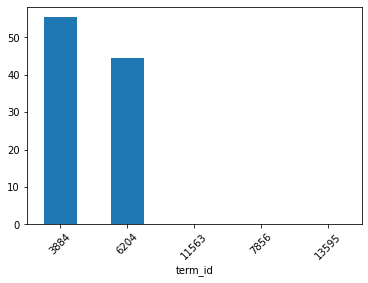

In [47]:
EIG_PAIRS.exp_var.sort_values(ascending=False).head().plot.bar(rot=45)

In [48]:
COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).reset_index(drop=True)
COMPS.index.name = 'comp_id'
COMPS.index = ["PC{}".format(i) for i in COMPS.index.tolist()]

In [49]:
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']
LOADINGS = COMPS[TERM_IDX].T
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

LOADINGS.index.name = 'term_id'

In [50]:
l0_pos = LOADINGS.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
l0_neg = LOADINGS.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
l1_pos = LOADINGS.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')
l1_neg = LOADINGS.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')

In [51]:
print('Books PC0+', l0_pos)
print('Books PC0-', l0_neg)
print('Books PC1+', l1_pos)
print('Books PC1-', l1_neg)

Books PC0+ dorian t don portrait painter sins club didn studio shallow
Books PC0- nt whilst managers ghost daroga viscount francs castle commissary ballet
Books PC1+ whilst castle wolves comfort vampire harbour wolf sunrise seemingly mate
Books PC1- managers ghost daroga francs viscount ballet commissary foyer cellars theater


In [52]:
DCM = TFIDF.dot(COMPS[TERM_IDX].T)


In [53]:
DCM=DCM.reset_index()

In [54]:
DCM

book_id       PC0      PC1           PC2           PC3           PC4  \
0      174 -0.831596  0.00703  8.402567e-19  2.710505e-20 -1.192622e-18   
1      175  0.422582  0.64276 -8.809143e-19 -3.117081e-19  2.710505e-19   
2      345  0.409013 -0.64979  4.201283e-19 -9.486769e-20  2.710505e-19   

            PC5           PC6           PC7           PC8           PC9  
0 -9.622294e-19 -3.523657e-19  7.047314e-19 -1.084202e-19 -1.084202e-18  
1 -1.626303e-19  2.439455e-19 -4.065758e-19  2.710505e-20 -8.131516e-19  
2  4.065758e-20 -5.285486e-19  6.369688e-19  1.179070e-18  4.878910e-19

In [55]:
VOCAB.loc[[int(x) for x in EIG_PAIRS.sort_values('exp_var', ascending=False).head(10).index], 'term_str']

term_id
3884        drowsily
6204         hungers
11563           sole
7856         methods
13595            vow
1223         benefit
13314    unspeakable
5476        glorious
4152        employed
9882         radiant
Name: term_str, dtype: object

### Show Loadings

In [251]:
LOADINGS


PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
term_id                                                                         
3760    -0.707792  0.007430  0.000000  0.000000  0.000000  0.000000  0.000000   
12410   -0.262507  0.001567  0.000118  0.000022 -0.000024 -0.000020  0.000024   
8408     0.282281 -0.023550 -0.000080 -0.000037 -0.000010  0.000021  0.000029   
3743    -0.152796  0.016259  0.000366 -0.000220 -0.000128  0.000065 -0.000052   
7598     0.158886  0.300105 -0.000066 -0.000066 -0.000004  0.000036 -0.000052   
...           ...       ...       ...       ...       ...       ...       ...   
3908    -0.001706  0.000018  0.015057 -0.001485 -0.006150  0.030572  0.002721   
6195    -0.001706  0.000018  0.021940  0.031480 -0.010486  0.024344  0.018293   
3906    -0.001706  0.000018  0.001776 -0.030079  0.016261  0.000406  0.021777   
6204    -0.001706  0.000018  0.025490  0.030450  0.010890 -0.014733  0.006166   
3884    -0.001706  0.000018 -0.012439  0.028776  0.025294  0.008687 -0.004470   

              PC7       PC8       PC9   term_str  
term_id                                           
3760     0.000000  0.000000  0.000000     dorian  
12410   -0.000041 -0.000275 -0.000040          t  
8408     0.000031  0.000281  0.000044         nt  
3743    -0.000033 -0.000291  0.000309        don  
7598    -0.000022 -0.000063  0.000306   managers  
...           ...       ...       ...        ...  
3908     0.006487 -0.006647 -0.006907  duchesses  
6195     0.018110 -0.005651 -0.005897     humped  
3906    -0.023797 -0.002670 -0.007041      ducal  
6204     0.001549 -0.014880 -0.005490    hungers  
3884    -0.016117 -0.009511  0.003543   drowsily  

[4000 rows x 11 columns]

In [56]:
LOADINGS = COMPS[TERM_IDX].T
LOADINGS.index.name = 'term_id'

In [57]:
LOADINGS.head().style.background_gradient()

In [58]:
LOADINGS['term_str'] = LOADINGS.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)


In [59]:
print('Books PC0+', l0_pos)
print('Books PC0-', l0_neg)
print('Books PC1+', l1_pos)
print('Books PC1-', l1_neg)

Books PC0+ dorian t don portrait painter sins club didn studio shallow
Books PC0- nt whilst managers ghost daroga viscount francs castle commissary ballet
Books PC1+ whilst castle wolves comfort vampire harbour wolf sunrise seemingly mate
Books PC1- managers ghost daroga francs viscount ballet commissary foyer cellars theater


In [60]:
L0 = TFIDF.astype('bool').astype('int')
L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
L2 = TFIDF.apply(lambda x: x / norm(x), 1)

In [61]:
TFIDF.groupby(['book_id']).mean()

term_id     3760      12410     8408      3743      7598      5389      9379   \
book_id                                                                         
174      0.588649  0.218311 -0.234909  0.127179 -0.130019 -0.122252  0.073758   
175     -0.294324 -0.109924  0.104150 -0.054118  0.260038  0.241432 -0.036879   
345     -0.294324 -0.108387  0.130760 -0.073060 -0.130019 -0.119179 -0.036879   

term_id    13830     3133      13551  ...     10961     10962     6187   \
book_id                               ...                                 
174     -0.13599 -0.083828 -0.078696  ...  0.001418  0.001418  0.001418   
175     -0.13599  0.167656  0.157391  ... -0.000709 -0.000709 -0.000709   
345      0.27198 -0.083828 -0.078696  ... -0.000709 -0.000709 -0.000709   

term_id     10732     12499     3908      6195      3906      6204      3884   
book_id                                                                        
174      0.001418  0.001418  0.001418  0.001418  0.001418  0.001418  0.001418  
175     -0.000709 -0.000709 -0.000709 -0.000709 -0.000709 -0.000709 -0.000709  
345     -0.000709 -0.000709 -0.000709 -0.000709 -0.000709 -0.000709 -0.000709  

[3 rows x 4000 columns]

In [257]:
pca_engine = PCA(n_components=3)

In [258]:
DCM_sk_b = pd.DataFrame(pca_engine.fit_transform(TFIDF), index=TFIDF.index)
DCM_sk_b.columns = ['PC{}'.format(i) for i in DCM_sk_b.columns]
DCM_sk_b['label'] = LIB.author
DCM_sk_b['title'] = LIB.book_title

In [259]:
DCM_sk_b.head().style.background_gradient()

In [246]:
LOADINGS_sk = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS_sk.columns = ["PC{}".format(i) for i in LOADINGS_sk.columns]

In [248]:
LOADINGS_sk.index = TFIDF.columns
LOADINGS_sk.index.name = 'term_id'
LOADINGS_sk['term_str'] = LOADINGS_sk.apply(lambda x: VOCAB.loc[int(x.name)].term_str, 1)

In [249]:
pc0_pos = LOADINGS_sk.sort_values('PC0', ascending=False).head(10).term_str.str.cat(sep=' ')
pc0_neg = LOADINGS_sk.sort_values('PC0', ascending=True).head(10).term_str.str.cat(sep=' ')
pc1_pos = LOADINGS_sk.sort_values('PC1', ascending=False).head(10).term_str.str.cat(sep=' ')
pc1_neg = LOADINGS_sk.sort_values('PC1', ascending=True).head(10).term_str.str.cat(sep=' ')

In [250]:
print('BOOKS PC0+', pc0_pos)
print('BOOKS PC0-', pc0_neg)
print('BOOKS PC1+', pc1_pos)
print('BOOKS PC1-', pc1_neg)

BOOKS PC0+ dorian t don portrait painter sins didn club studio shallow
BOOKS PC0- nt whilst managers ghost daroga francs viscount castle commissary ballet
BOOKS PC1+ whilst castle wolves comfort harbour sunrise wolf vampire mate seemingly
BOOKS PC1- managers ghost daroga viscount francs ballet commissary foyer cellars theater


In [260]:
def vis_pcs(M, a, b, prefix='PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                        color='label', 
                        hover_name='title', marginal_x='box')
    fig.show()

In [267]:
vis_pcs(DCM_sk_b, 0,2)


In [254]:
LOADINGS.to_csv('docs/LOADING.csv')

PC0       PC1       PC2       PC3       PC4       PC5       PC6  \
term_id                                                                         
3760    -0.707792  0.007430  0.000000  0.000000  0.000000  0.000000  0.000000   
12410   -0.262507  0.001567  0.000118  0.000022 -0.000024 -0.000020  0.000024   
8408     0.282281 -0.023550 -0.000080 -0.000037 -0.000010  0.000021  0.000029   
3743    -0.152796  0.016259  0.000366 -0.000220 -0.000128  0.000065 -0.000052   
7598     0.158886  0.300105 -0.000066 -0.000066 -0.000004  0.000036 -0.000052   
...           ...       ...       ...       ...       ...       ...       ...   
3908    -0.001706  0.000018  0.015057 -0.001485 -0.006150  0.030572  0.002721   
6195    -0.001706  0.000018  0.021940  0.031480 -0.010486  0.024344  0.018293   
3906    -0.001706  0.000018  0.001776 -0.030079  0.016261  0.000406  0.021777   
6204    -0.001706  0.000018  0.025490  0.030450  0.010890 -0.014733  0.006166   
3884    -0.001706  0.000018 -0.012439  0.028776  0.025294  0.008687 -0.004470   

              PC7       PC8       PC9   term_str  
term_id                                           
3760     0.000000  0.000000  0.000000     dorian  
12410   -0.000041 -0.000275 -0.000040          t  
8408     0.000031  0.000281  0.000044         nt  
3743    -0.000033 -0.000291  0.000309        don  
7598    -0.000022 -0.000063  0.000306   managers  
...           ...       ...       ...        ...  
3908     0.006487 -0.006647 -0.006907  duchesses  
6195     0.018110 -0.005651 -0.005897     humped  
3906    -0.023797 -0.002670 -0.007041      ducal  
6204     0.001549 -0.014880 -0.005490    hungers  
3884    -0.016117 -0.009511  0.003543   drowsily  

[4000 rows x 11 columns]

### LDA

In [67]:
n_terms = 4000
n_topics = 30
max_iter = 5
OHCO = ['book_id', 'chap_num', 'para_num']

In [63]:
BOOKS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO[:1]).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'book_str'})

In [66]:
TOKEN

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                   
174     1        1        0        0                (The, DT)   DT       The   
                                   1             (studio, NN)   NN    studio   
                                   2               (was, VBD)  VBD       was   
                                   3            (filled, VBN)  VBN    filled   
                                   4               (with, IN)   IN      with   
...                                                       ...  ...       ...   
345     24       78       2        29                  (., .)    .         .   
                                   30                ('', '')   ''        ''   
                 79       0        0          (JONATHAN, NNP)  NNP  JONATHAN   
                                   1            (HARKER, NNP)  NNP    HARKER   
                                   2                   (., .)    .         .   

                                              term_str  term_id  
book_id chap_num para_num sent_num token_num                     
174     1        1        0        0               the    12580  
                                   1            studio    12101  
                                   2               was    13693  
                                   3            filled     4804  
                                   4              with    13962  
...                                                ...      ...  
345     24       78       2        29                         0  
                                   30                         0  
                 79       0        0          jonathan     6862  
                                   1            harker     5810  
                                   2                          0  

[385930 rows x 5 columns]

In [68]:

PARAS = TOKEN[TOKEN.pos.str.match(r'^NNS?$')]\
    .groupby(OHCO).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'para_str'})

In [69]:
tfv = CountVectorizer(max_features=n_terms, stop_words='english')
tf = tfv.fit_transform(PARAS.para_str)
TERMS = tfv.get_feature_names()

C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [70]:
tfv2 = CountVectorizer(max_features=n_terms, stop_words='english')
tf2 = tfv.fit_transform(BOOKS.book_str)
TERMS2 = tfv.get_feature_names()

In [71]:
lda = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)
lda2 = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [72]:
THETA = pd.DataFrame(lda.fit_transform(tf), index=PARAS.index)
THETA.columns.name = 'topic_id'

In [73]:
THETA2 = pd.DataFrame(lda2.fit_transform(tf2), index=BOOKS.index)
THETA2.columns.name = 'topic_id'

In [74]:
THETA.sample(20).style.background_gradient()

In [75]:
THETA2.sample(3).style.background_gradient()

In [76]:
PHI = pd.DataFrame(lda.components_, columns=TERMS)
PHI.index.name = 'topic_id'
PHI.columns.name  = 'term_str'
PHI2 = pd.DataFrame(lda2.components_, columns=TERMS)
PHI2.index.name = 'topic_id'
PHI2.columns.name  = 'term_str'

In [77]:
PHI.T.head().style.background_gradient()

In [78]:
PHI2.T.head().style.background_gradient()

In [79]:
TOPICS = PHI.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

C:\Users\laure\AppData\Local\Temp/ipykernel_28828/1587940045.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [80]:
TOPICS2 = PHI2.stack().to_frame().rename(columns={0:'weight'})\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(10)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

C:\Users\laure\AppData\Local\Temp/ipykernel_28828/2856300834.py:4: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



<AxesSubplot:ylabel='label'>

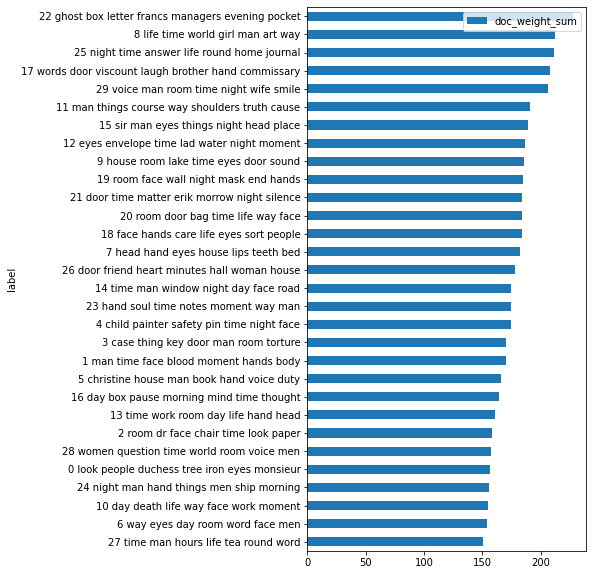

In [81]:
TOPICS['label'] = TOPICS.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')), 1)
TOPICS2['label'] = TOPICS2.apply(lambda x: str(x.name) + ' ' + ' '.join(x[:7].astype('str')), 1)
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS2['doc_weight_sum'] = THETA2.sum()
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

<AxesSubplot:ylabel='label'>

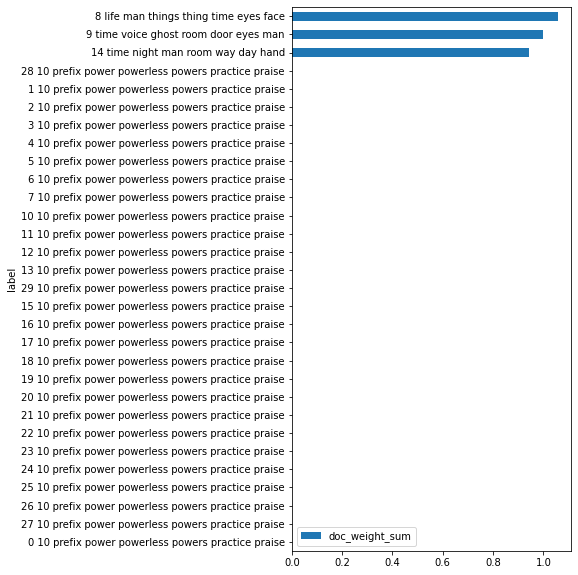

In [82]:
TOPICS2.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5,10)) 

In [83]:
topic_cols = [t for t in range(n_topics)]

In [87]:
LIB

book_title          author         book_file
book_id                                                              
174      The Picture of Dorian Gray     Oscar Wilde  books\pg-174.txt
175        The Phantom of the Opera   Gaston Leroux  books\pg-175.txt
345                         Dracula     Bram Stoker  books\pg-345.txt

In [85]:
AUTHORS = THETA.join(LIB, on='book_id')\
    .reset_index().set_index(['author']+OHCO)\
    .groupby('author')[topic_cols].mean()\
    .T                                            
AUTHORS.index.name = 'topic_id'
AUTHORS['topterms'] = TOPICS[[i for i in range(10)]].apply(lambda x: ' '.join(x), 1)

In [89]:
AUTHORS

author     Bram Stoker   Gaston Leroux   Oscar Wilde  \
topic_id                                               
0             0.021544        0.032896      0.033673   
1             0.043412        0.025007      0.026077   
2             0.039964        0.021831      0.026920   
3             0.031062        0.027615      0.038315   
4             0.032384        0.024042      0.044374   
5             0.023534        0.038383      0.030529   
6             0.034119        0.027903      0.023326   
7             0.038971        0.031058      0.031738   
8             0.038961        0.020773      0.066383   
9             0.023774        0.046535      0.032157   
10            0.028962        0.030273      0.027120   
11            0.036017        0.033860      0.037268   
12            0.023257        0.043136      0.037976   
13            0.040975        0.019634      0.030328   
14            0.050992        0.023912      0.021391   
15            0.034526        0.027592      0.046516   
16            0.032603        0.028277      0.031660   
17            0.028560        0.056855      0.027336   
18            0.038161        0.026533      0.039922   
19            0.034350        0.035920      0.032671   
20            0.031770        0.043416      0.025262   
21            0.034788        0.038895      0.027619   
22            0.025371        0.070612      0.026055   
23            0.035106        0.033777      0.027700   
24            0.027616        0.026749      0.033982   
25            0.045175        0.034595      0.039173   
26            0.035997        0.031934      0.031294   
27            0.031079        0.027568      0.024788   
28            0.027896        0.025787      0.036211   
29            0.029076        0.044629      0.042237   

author                                             topterms  
topic_id                                                     
0         look people duchess tree iron eyes monsieur by...  
1         man time face blood moment hands body way room...  
2         room dr face chair time look paper way life brain  
3         case thing key door man room torture chamber h...  
4         child painter safety pin time night face thing...  
5         christine house man book hand voice duty time ...  
6         way eyes day room word face men performance bl...  
7         head hand eyes house lips teeth bed throat han...  
8         life time world girl man art way things friend...  
9         house room lake time eyes door sound man day h...  
10        day death life way face work moment head geniu...  
11        man things course way shoulders truth cause ey...  
12        eyes envelope time lad water night moment face...  
13        time work room day life hand head night moment...  
14        time man window night day face road place way ...  
15        sir man eyes things night head place passage t...  
16        day box pause morning mind time thought count ...  
17        words door viscount laugh brother hand commiss...  
18        face hands care life eyes sort people dear man...  
19        room face wall night mask end hands knees day ...  
20        room door bag time life way face evening ocloc...  
21        door time matter erik morrow night silence mon...  
22        ghost box letter francs managers evening pocke...  
23        hand soul time notes moment way man barrels ro...  
24        night man hand things men ship morning gentlem...  
25        night time answer life round home journal mome...  
26        door friend heart minutes hall woman house nig...  
27        time man hours life tea round word things wate...  
28        women question time world room voice men life ...  
29        voice man room time night wife smile love door...

In [94]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, 10))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [95]:
SIMS = pdist(normalize(PHI), metric='euclidean')
TREE = sch.linkage(SIMS, method='ward')

In [96]:
labels  = ["{}: {}".format(a,b) for a, b in zip(AUTHORS.index,  AUTHORS.topterms.tolist())]

<Figure size 432x288 with 0 Axes>

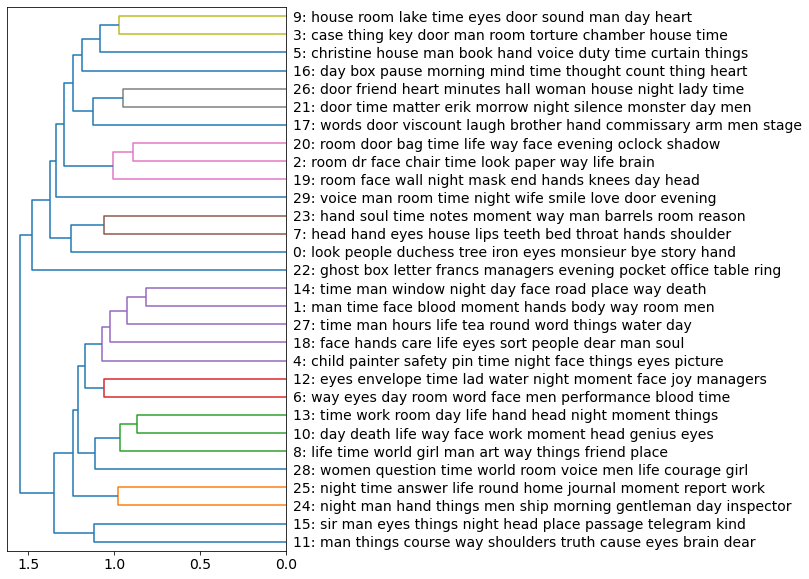

In [97]:
plot_tree(TREE, labels)

### word2vec

In [ ]:
TOKEN

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                   
174     1        1        0        0                (The, DT)   DT       The   
                                   1             (studio, NN)   NN    studio   
                                   2               (was, VBD)  VBD       was   
                                   3            (filled, VBN)  VBN    filled   
                                   4               (with, IN)   IN      with   
...                                                       ...  ...       ...   
345     24       78       2        29                  (., .)    .         .   
                                   30                ('', '')   ''        ''   
                 79       0        0          (JONATHAN, NNP)  NNP  JONATHAN   
                                   1            (HARKER, NNP)  NNP    HARKER   
                                   2                   (., .)    .         .   

                                              term_str  term_id  
book_id chap_num para_num sent_num token_num                     
174     1        1        0        0               the    10741  
                                   1            studio    10334  
                                   2               was    11683  
                                   3            filled     4078  
                                   4              with    11932  
...                                                ...      ...  
345     24       78       2        29                         0  
                                   30                         0  
                 79       0        0          jonathan     5834  
                                   1            harker     4956  
                                   2                          0  

[283122 rows x 5 columns]

In [100]:
DORIAN_TOKENS = TOKEN.query('book_id == 174')
PHANTOM_TOKENS = TOKEN.query('book_id == 175')
DRACULA_TOKENS = TOKEN.query('book_id == 345')
BAG = OHCO[:3] #Paragraphs
window = 5

In [101]:
DORIAN_TOKENS

pos_tuple  pos token_str  \
book_id chap_num para_num sent_num token_num                                  
174     1        1        0        0               (The, DT)   DT       The   
                                   1            (studio, NN)   NN    studio   
                                   2              (was, VBD)  VBD       was   
                                   3           (filled, VBN)  VBN    filled   
                                   4              (with, IN)   IN      with   
...                                                      ...  ...       ...   
        20       23       7        11                 (., .)    .         .   
                 24       0        0             (START, NN)   NN     START   
                                   1                  (:, :)    :         :   
                                   2             (FULL, NNP)  NNP      FULL   
                                   3          (LICENSE, NNP)  NNP   LICENSE   

                                             term_str  term_id  
book_id chap_num para_num sent_num token_num                    
174     1        1        0        0              the    12580  
                                   1           studio    12101  
                                   2              was    13693  
                                   3           filled     4804  
                                   4             with    13962  
...                                               ...      ...  
        20       23       7        11                        0  
                 24       0        0            start    11853  
                                   1                         0  
                                   2             full     5206  
                                   3          license     7256  

[96941 rows x 5 columns]

#### A Christmas Carol

In [117]:
corpus = DORIAN_TOKENS[~DORIAN_TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()


## Generate word embeddings with Gensim's library
a_model = word2vec.Word2Vec(corpus, vector_size=200, window=window, min_count=50, workers=4)

## Visualize with tSNE

## Generate Coordinates to Plot

coords = pd.DataFrame(index=range(len(a_model.wv)))
coords['label'] = [w for w in a_model.wv.index_to_key]
coords['vector'] = coords['label'].apply(lambda x: a_model.wv.get_vector(x))

### Use ScikitLearn's TSNE library

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values = tsne_model.fit_transform(coords['vector'].tolist())
coords['x'] = tsne_values[:,0]
coords['y'] = tsne_values[:,1]

## Plot the Coordinates 
px.scatter(coords, 'x', 'y', text='label', height=1000, title="Dorian Gray").update_traces(mode='text')

C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [113]:
corpus = PHANTOM_TOKENS[~PHANTOM_TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()


## Generate word embeddings with Gensim's library
b_model = word2vec.Word2Vec(corpus, vector_size=100, window=window, min_count=20, workers=4)

## Visualize with tSNE

## Generate Coordinates to Plot

coords = pd.DataFrame(index=range(len(b_model.wv)))
coords['label'] = [w for w in b_model.wv.index_to_key]
coords['vector'] = coords['label'].apply(lambda x: b_model.wv.get_vector(x))

### Use ScikitLearn's TSNE library

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values = tsne_model.fit_transform(coords['vector'].tolist())
coords['x'] = tsne_values[:,0]
coords['y'] = tsne_values[:,1]

## Plot the Coordinates 
px.scatter(coords, 'x', 'y', text='label', height=1000, title="Phantom of the Opera").update_traces(mode='text')


C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [119]:
corpus = DRACULA_TOKENS[~DRACULA_TOKENS.pos.str.match('NNPS?')]\
    .groupby(BAG)\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()


## Generate word embeddings with Gensim's library
C_model = word2vec.Word2Vec(corpus, vector_size=100, window=window, min_count=20, workers=4)

## Visualize with tSNE

## Generate Coordinates to Plot

coords = pd.DataFrame(index=range(len(C_model.wv)))
coords['label'] = [w for w in C_model.wv.index_to_key]
coords['vector'] = coords['label'].apply(lambda x: C_model.wv.get_vector(x))

### Use ScikitLearn's TSNE library

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
tsne_values = tsne_model.fit_transform(coords['vector'].tolist())
coords['x'] = tsne_values[:,0]
coords['y'] = tsne_values[:,1]

## Plot the Coordinates 
px.scatter(coords, 'x', 'y', text='label', height=1000, title="Dracula").update_traces(mode='text')


C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

C:\Users\laure\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



## Sentiment Analysis

In [138]:
OHCO = ['author', 'book_title', 'chap_num', 'para_num', 'sent_num']
CHAPS = OHCO[2:3]
PARAS = OHCO[2:4]
SENTS = OHCO[2:5]

phantom = ("Gaston Leroux","The Phantom of the Opera")
dracula = ('Bram Stoker', "Dracula")
dorian = ("Oscar Wilde", "The Picture of Dorian Gray")

salex_csv = 'salex_nrc.csv'
nrc_cols = "nrc_negative nrc_positive nrc_anger nrc_anticipation nrc_disgust nrc_fear nrc_joy nrc_sadness nrc_surprise nrc_trust".split()
emo = 'polarity'

In [122]:
salex = pd.read_csv(salex_csv).set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]
salex['polarity'] = salex.positive - salex.negative
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

anger  anticipation  disgust  fear  joy  negative  positive  \
term_str                                                                   
abandon          0             0        0     1    0         1         0   
abandoned        1             0        0     1    0         1         0   
abandonment      1             0        0     1    0         1         0   
abduction        0             0        0     1    0         1         0   
aberration       0             0        1     0    0         1         0   
...            ...           ...      ...   ...  ...       ...       ...   
young            0             1        0     0    1         0         1   
youth            1             1        0     1    1         0         1   
zeal             0             1        0     0    1         0         1   
zealous          0             0        0     0    1         0         1   
zest             0             1        0     0    1         0         1   

             sadness  surprise  trust  polarity  
term_str                                         
abandon            1         0      0        -1  
abandoned          1         0      0        -1  
abandonment        1         1      0        -1  
abduction          1         1      0        -1  
aberration         0         0      0        -1  
...              ...       ...    ...       ...  
young              0         1      0         1  
youth              0         1      0         1  
zeal               0         1      1         1  
zealous            0         0      1         1  
zest               0         0      1         1  

[3688 rows x 11 columns]

In [130]:
TOKEN.reset_index(inplace=True)

In [152]:

TOKEN = TOKEN.merge(LIB, on='book_id')

In [154]:
TOKEN = TOKEN.set_index(OHCO).sort_index()

In [155]:
TOKEN = TOKEN.join(salex, on='term_str', how='left')

In [157]:
TOKEN[emo_cols] = TOKEN[emo_cols].fillna(0)

In [160]:
TOKEN[salex.columns].sample(10)

anger  \
author       book_title                 chap_num para_num sent_num          
 Bram Stoker Dracula                    7        51       11          0.0   
                                        22       56       1           0.0   
                                        18       18       3           0.0   
 Oscar Wilde The Picture of Dorian Gray 2        81       0           0.0   
                                        11       17       2           0.0   
 Bram Stoker Dracula                    24       27       8           0.0   
 Oscar Wilde The Picture of Dorian Gray 4        100      10          0.0   
 Bram Stoker Dracula                    9        65       9           0.0   
                                        18       5        3           0.0   
 Oscar Wilde The Picture of Dorian Gray 18       6        1           0.0   

                                                                    anticipation  \
author       book_title                 chap_num para_num sent_num                 
 Bram Stoker Dracula                    7        51       11                 0.0   
                                        22       56       1                  0.0   
                                        18       18       3                  0.0   
 Oscar Wilde The Picture of Dorian Gray 2        81       0                  0.0   
                                        11       17       2                  0.0   
 Bram Stoker Dracula                    24       27       8                  0.0   
 Oscar Wilde The Picture of Dorian Gray 4        100      10                 0.0   
 Bram Stoker Dracula                    9        65       9                  0.0   
                                        18       5        3                  0.0   
 Oscar Wilde The Picture of Dorian Gray 18       6        1                  0.0   

                                                                    disgust  \
author       book_title                 chap_num para_num sent_num            
 Bram Stoker Dracula                    7        51       11            0.0   
                                        22       56       1             0.0   
                                        18       18       3             0.0   
 Oscar Wilde The Picture of Dorian Gray 2        81       0             0.0   
                                        11       17       2             0.0   
 Bram Stoker Dracula                    24       27       8             0.0   
 Oscar Wilde The Picture of Dorian Gray 4        100      10            0.0   
 Bram Stoker Dracula                    9        65       9             0.0   
                                        18       5        3             0.0   
 Oscar Wilde The Picture of Dorian Gray 18       6        1             0.0   

                                                                    fear  joy  \
author       book_title                 chap_num para_num sent_num              
 Bram Stoker Dracula                    7        51       11         0.0  0.0   
                                        22       56       1          0.0  0.0   
                                        18       18       3          0.0  0.0   
 Oscar Wilde The Picture of Dorian Gray 2        81       0          0.0  0.0   
                                        11       17       2          0.0  0.0   
 Bram Stoker Dracula                    24       27       8          0.0  1.0   
 Oscar Wilde The Picture of Dorian Gray 4        100      10         0.0  0.0   
 Bram Stoker Dracula                    9        65       9          0.0  0.0   
                                        18       5        3          0.0  0.0   
 Oscar Wilde The Picture of Dorian Gray 18       6        1          0.0  0.0   

                                                                    negative  \
author       book_title                 chap_num para_num sent_num             
 Bram Stoker Dracula                    7        51 

In [161]:


TOKEN[['term_str'] + emo_cols].sample(10)
TOKEN[emo_cols] = TOKEN[emo_cols].fillna(0)
TOKEN.head()


book_id  token_num  \
author       book_title chap_num para_num sent_num                       
 Bram Stoker Dracula    1        0        0             345          0   
                                          0             345          1   
                                          0             345          2   
                                          0             345          3   
                                          0             345          4   

                                                          pos_tuple  pos  \
author       book_title chap_num para_num sent_num                         
 Bram Stoker Dracula    1        0        0         (JONATHAN, NNP)  NNP   
                                          0           (HARKER, NNP)  NNP   
                                          0               ('S, POS)  POS   
                                          0          (JOURNAL, NNP)  NNP   
                                          0                  (-, :)    :   

                                                   token_str  term_str  \
author       book_title chap_num para_num sent_num                       
 Bram Stoker Dracula    1        0        0         JONATHAN  jonathan   
                                          0           HARKER    harker   
                                          0               'S         s   
                                          0          JOURNAL   journal   
                                          0                -             

                                                    term_id         book_file  \
author       book_title chap_num para_num sent_num                              
 Bram Stoker Dracula    1        0        0            6862  books\pg-345.txt   
                                          0            5810  books\pg-345.txt   
                                          0           10656  books\pg-345.txt   
                                          0            6871  books\pg-345.txt   
                                          0               0  books\pg-345.txt   

                                                    anger  anticipation  \
author       book_title chap_num para_num sent_num                        
 Bram Stoker Dracula    1        0        0           0.0           0.0   
                                          0           0.0           0.0   
                                          0           0.0           0.0   
                                          0           0.0           0.0   
                                          0           0.0           0.0   

                                                    disgust  fear  joy  \
author       book_title chap_num para_num sent_num                       
 Bram Stoker Dracula    1        0        0             0.0   0.0  0.0   
                                          0             0.0   0.0  0.0   
                                          0             0.0   0.0  0.0   
                                          0             0.0   0.0  0.0   
                                          0             0.0   0.0  0.0   

                                                    negative  positive  \
author       book_title chap_num para_num sent_num                       
 Bram Stoker Dracula    1        0        0              NaN       NaN   
                                          0              NaN       NaN   
                                          0              NaN       NaN   
                                          0              NaN       NaN   
                                          0              NaN       NaN   

                                                    sadness  surprise  trust  \
author       book_title chap_num para_num sent_num                             
 Bram Stoker Dracula    1        0        0             0.0       0.0    0.0   
                                          0             0.0       0.0    0.0   
                             

In [163]:
TOKEN[['term_str'] + emo_cols].sample(10)

term_str  \
author         book_title                 chap_num para_num sent_num            
 Bram Stoker   Dracula                    22       85       10             us   
 Gaston Leroux The Phantom of the Opera   20       79       7                   
 Bram Stoker   Dracula                    17       67       1                   
 Gaston Leroux The Phantom of the Opera   5        2        0         richard   
 Bram Stoker   Dracula                    7        6        5            soon   
                                          6        16       17         afraid   
 Oscar Wilde   The Picture of Dorian Gray 9        22       1          rather   
 Gaston Leroux The Phantom of the Opera   9        14       2            king   
 Bram Stoker   Dracula                    13       11       2             and   
 Gaston Leroux The Phantom of the Opera   16       9        2                   

                                                                      anger  \
author         book_title                 chap_num para_num sent_num          
 Bram Stoker   Dracula                    22       85       10          0.0   
 Gaston Leroux The Phantom of the Opera   20       79       7           0.0   
 Bram Stoker   Dracula                    17       67       1           0.0   
 Gaston Leroux The Phantom of the Opera   5        2        0           0.0   
 Bram Stoker   Dracula                    7        6        5           0.0   
                                          6        16       17          0.0   
 Oscar Wilde   The Picture of Dorian Gray 9        22       1           0.0   
 Gaston Leroux The Phantom of the Opera   9        14       2           0.0   
 Bram Stoker   Dracula                    13       11       2           0.0   
 Gaston Leroux The Phantom of the Opera   16       9        2           0.0   

                                                                      anticipation  \
author         book_title                 chap_num para_num sent_num                 
 Bram Stoker   Dracula                    22       85       10                 0.0   
 Gaston Leroux The Phantom of the Opera   20       79       7                  0.0   
 Bram Stoker   Dracula                    17       67       1                  0.0   
 Gaston Leroux The Phantom of the Opera   5        2        0                  0.0   
 Bram Stoker   Dracula                    7        6        5                  0.0   
                                          6        16       17                 0.0   
 Oscar Wilde   The Picture of Dorian Gray 9        22       1                  0.0   
 Gaston Leroux The Phantom of the Opera   9        14       2                  0.0   
 Bram Stoker   Dracula                    13       11       2                  0.0   
 Gaston Leroux The Phantom of the Opera   16       9        2                  0.0   

                                                                      disgust  \
author         book_title                 chap_num para_num sent_num            
 Bram Stoker   Dracula                    22       85       10            0.0   
 Gaston Leroux The Phantom of the Opera   20       79       7             0.0   
 Bram Stoker   Dracula                    17       67       1             0.0   
 Gaston Leroux The Phantom of the Opera   5        2        0             0.0   
 Bram Stoker   Dracula                    7        6        5             0.0   
                                          6        16       17            0.0   
 Oscar Wilde   The Picture of Dorian Gray 9        22       1             0.0   
 Gaston Leroux The Phantom of the Opera   9        14       2             0.0   
 Bram Stoker   Dracula                    13       11       2             0.0   
 Gaston Leroux The Phantom of the Opera   16       9        2             0.0   

                                                                      fear  \
author         book_title                 chap_num para_num sen

In [184]:
TOKEN

book_id  \
author       book_title                 chap_num para_num sent_num            
 Bram Stoker Dracula                    1        0        0             345   
                                                          0             345   
                                                          0             345   
                                                          0             345   
                                                          0             345   
...                                                                     ...   
 Oscar Wilde The Picture of Dorian Gray 20       23       7             174   
                                                 24       0             174   
                                                          0             174   
                                                          0             174   
                                                          0             174   

                                                                    token_num  \
author       book_title                 chap_num para_num sent_num              
 Bram Stoker Dracula                    1        0        0                 0   
                                                          0                 1   
                                                          0                 2   
                                                          0                 3   
                                                          0                 4   
...                                                                       ...   
 Oscar Wilde The Picture of Dorian Gray 20       23       7                11   
                                                 24       0                 0   
                                                          0                 1   
                                                          0                 2   
                                                          0                 3   

                                                                          pos_tuple  \
author       book_title                 chap_num para_num sent_num                    
 Bram Stoker Dracula                    1        0        0         (JONATHAN, NNP)   
                                                          0           (HARKER, NNP)   
                                                          0               ('S, POS)   
                                                          0          (JOURNAL, NNP)   
                                                          0                  (-, :)   
...                                                                             ...   
 Oscar Wilde The Picture of Dorian Gray 20       23       7                  (., .)   
                                                 24       0             (START, NN)   
                                                          0                  (:, :)   
                                                          0             (FULL, NNP)   
                                                          0          (LICENSE, NNP)   

                                                                    pos  \
author       book_title                 chap_num para_num sent_num        
 Bram Stoker Dracula                    1        0        0         NNP   
                                                          0         NNP   
                                                          0         POS   
                                                          0         NNP   
                                                          0           :   
...                                                                 ...   
 Oscar Wilde The Picture of Dorian Gray 20       23       7           .   
                                                 24       0          NN   
                                                          0           :   
                             

In [192]:
DRACULA = TOKEN.loc[TOKEN['book_id']==345].copy()
DORIAN = TOKEN.loc[TOKEN['book_id']==174].copy()
PHANTOM = TOKEN.loc[TOKEN['book_id']==175].copy()

<AxesSubplot:>

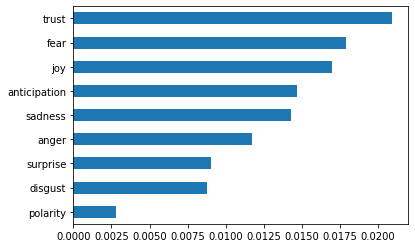

In [193]:
DRACULA[emo_cols].mean().sort_values().plot.barh()

<AxesSubplot:>

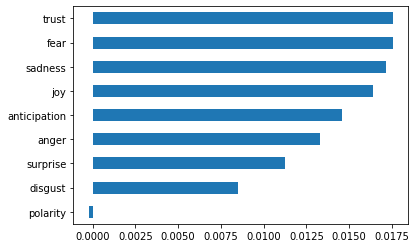

In [194]:
PHANTOM[emo_cols].mean().sort_values().plot.barh()

<AxesSubplot:>

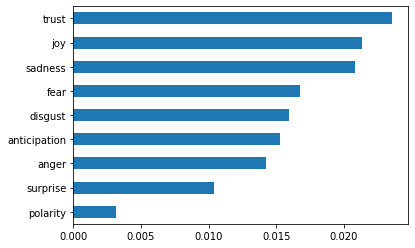

In [195]:
DORIAN[emo_cols].mean().sort_values().plot.barh()

Sentiment by Chapter

In [196]:
DRACULA_chaps = DRACULA.groupby(CHAPS)[emo_cols].mean()
DORIAN_chaps = DORIAN.groupby(CHAPS)[emo_cols].mean()
PHANTOM_chaps = PHANTOM.groupby(CHAPS)[emo_cols].mean()

In [197]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)
    df[emo].plot(**FIG)

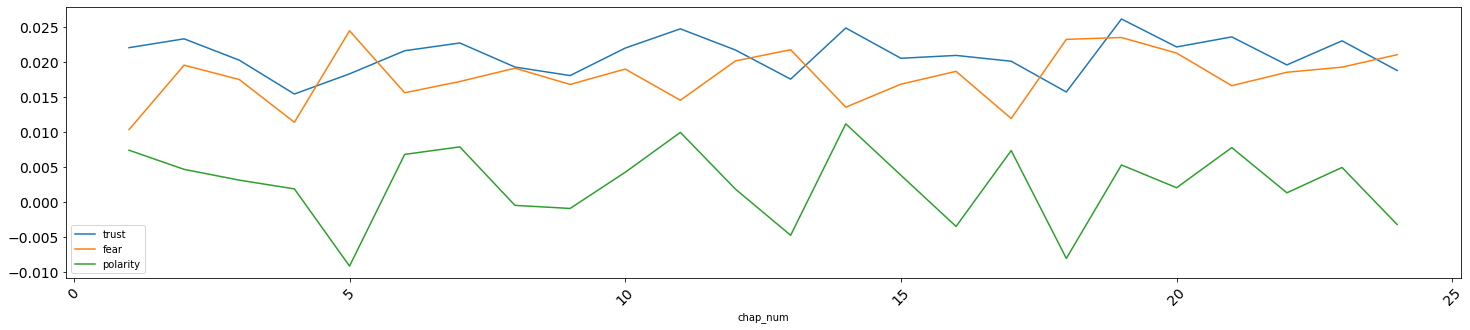

In [202]:
plot_sentiments(DRACULA_chaps, ['trust', 'fear', 'polarity'])

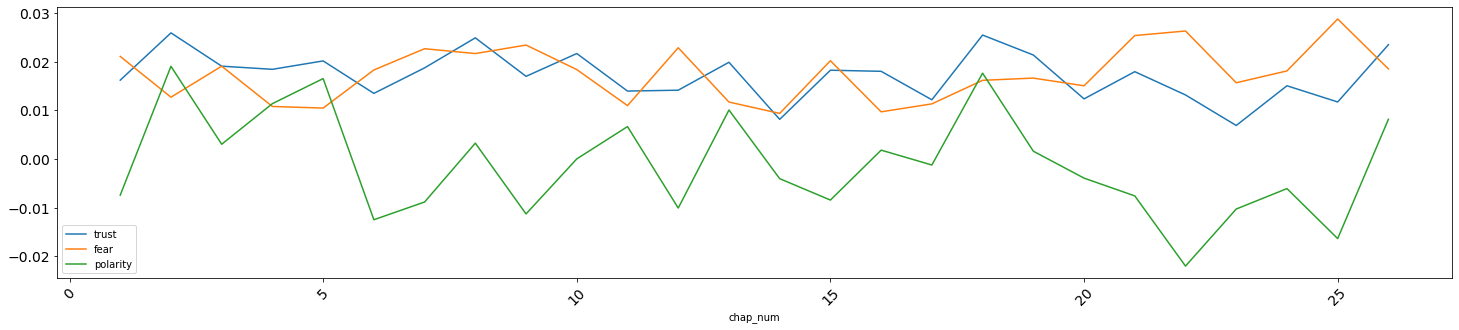

In [203]:
plot_sentiments(PHANTOM_chaps, ['trust', 'fear', 'polarity'])


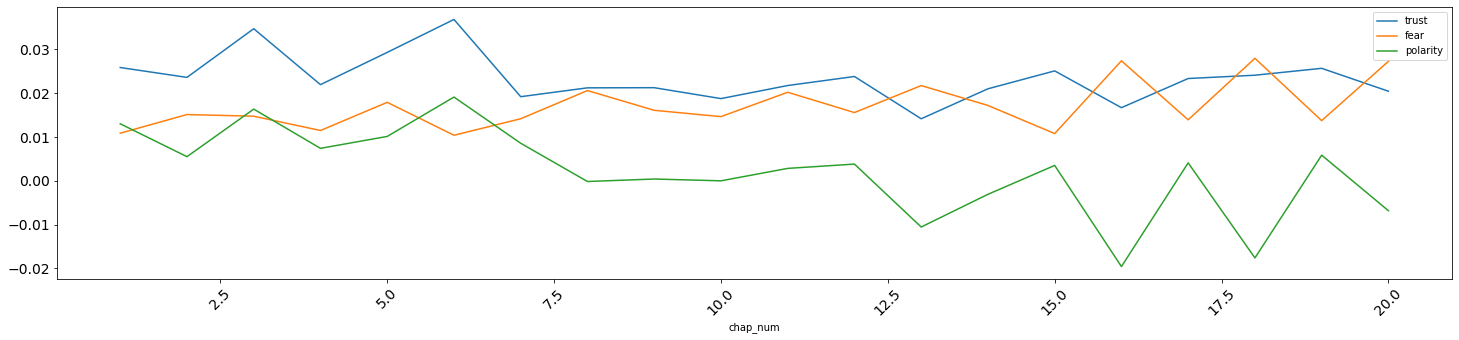

In [204]:
plot_sentiments(DORIAN_chaps, ['trust', 'fear', 'polarity'])


More Exploring

In [205]:
DRACULA['html'] =  DRACULA.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
DORIAN['html'] =  DORIAN.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)
PHANTOM['html'] =  PHANTOM.apply(lambda x: "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [206]:
DRACULA_sents = DRACULA.groupby(SENTS)[emo_cols].mean()
DORIAN_sents = DORIAN.groupby(SENTS)[emo_cols].mean()
PHANTOM_sents = PHANTOM.groupby(SENTS)[emo_cols].mean()

In [207]:
DRACULA_sents['sent_str'] = DRACULA.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
DRACULA_sents['html_str'] = DRACULA.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

DORIAN_sents['sent_str'] = DORIAN.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
DORIAN_sents['html_str'] = DORIAN.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

PHANTOM_sents['sent_str'] = PHANTOM.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
PHANTOM_sents['html_str'] = PHANTOM.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [226]:
def sample_sentences(df):
    rows = []
    for idx in df.sample(10).index:

        valence = round(df.loc[idx, emo], 4)     
        t = 0
        if valence > t: color = '#b6d7a8'
        elif valence < t: color = '#d49292'
        else: color = '#bcbcbc'
        z=0
        rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
        <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
        </tr>""".format(color, valence, df.loc[idx, 'html_str'], idx))

    display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
    display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

In [227]:
sample_sentences(DRACULA_sents)

In [228]:
sample_sentences(DORIAN_sents)

In [229]:
sample_sentences(PHANTOM_sents)

VADER

In [230]:
analyser = SentimentIntensityAnalyzer()

NameError: name 'SentimentIntensityAnalyzer' is not defined

In [234]:
DRACULA_vader_cols = DRACULA_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
DRACULA_vader = pd.concat([DRACULA_sents, DRACULA_vader_cols], axis=1)
DORIAN_vader_cols = DORIAN_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
DORIAN_vader = pd.concat([DORIAN_sents, DORIAN_vader_cols], axis=1)
PHANTOM_vader_cols = PHANTOM_sents.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
PHANTOM_vader = pd.concat([PHANTOM_sents, PHANTOM_vader_cols], axis=1)

<AxesSubplot:xlabel='chap_num,para_num,sent_num'>

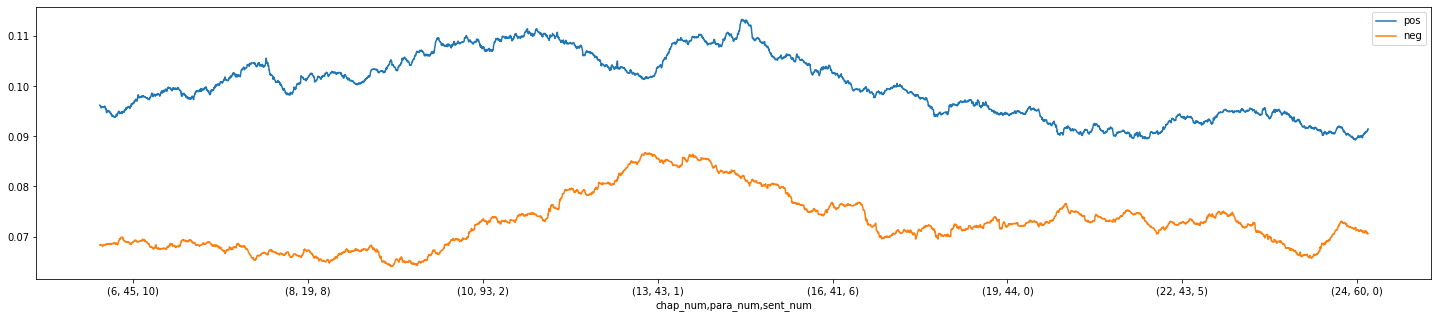

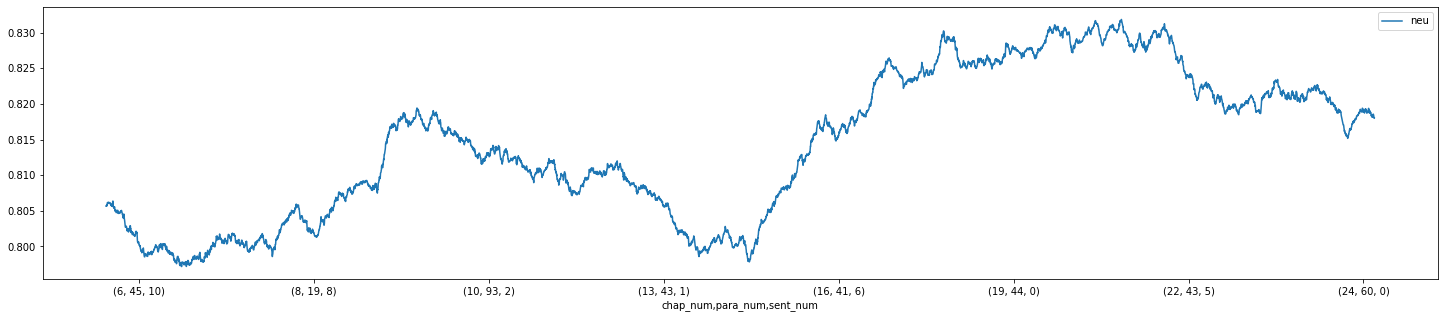

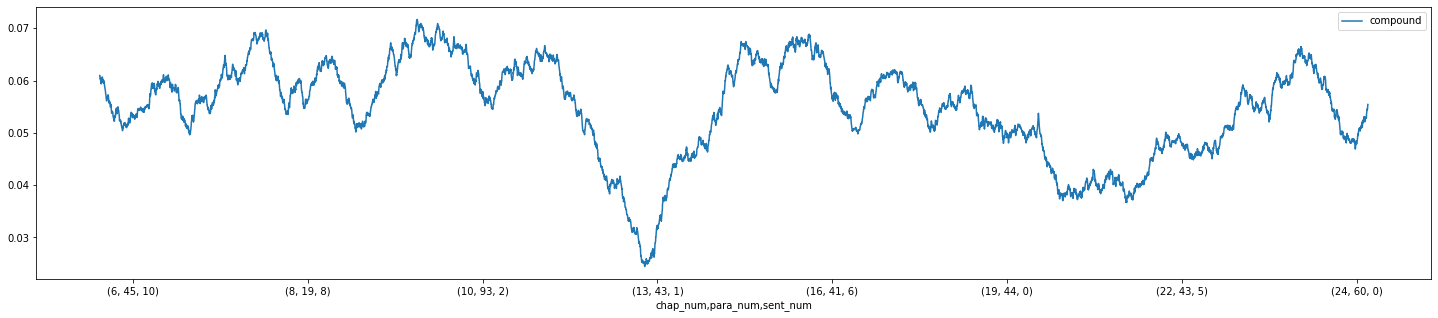

In [235]:
w = int(DRACULA_vader.shape[0] / 5)
DRACULA_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
DRACULA_vader[['neu']].rolling(w).mean().plot(figsize=(25,5))
DRACULA_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

<AxesSubplot:xlabel='chap_num,para_num,sent_num'>

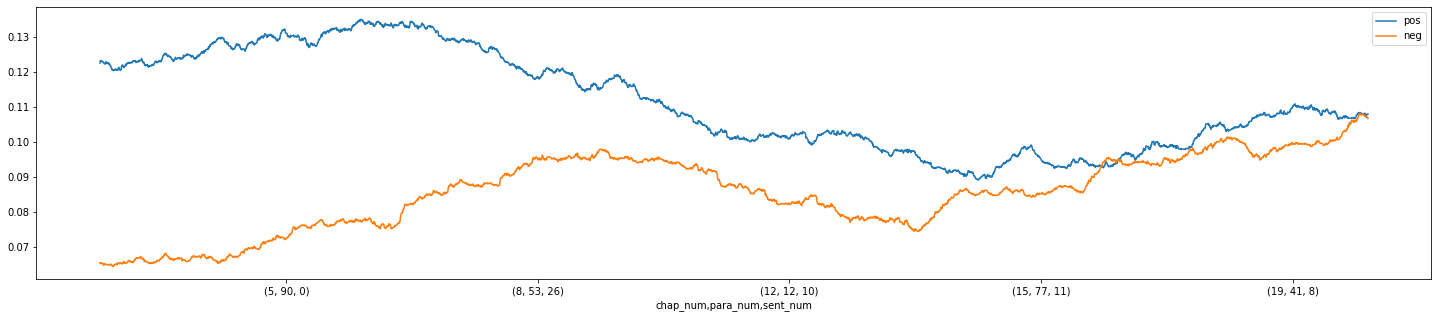

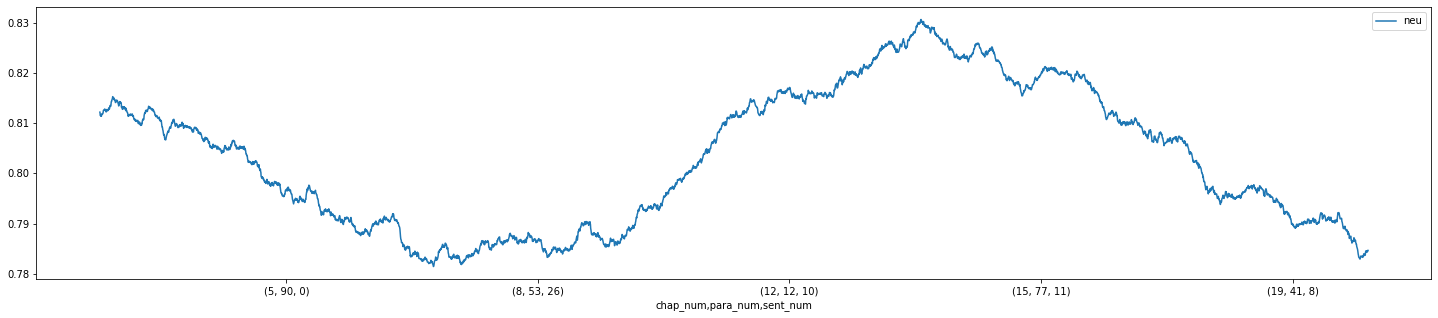

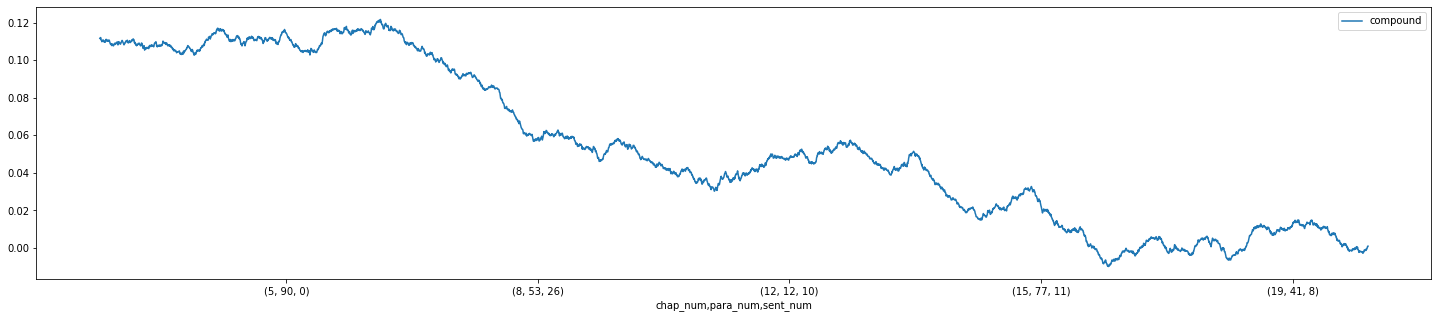

In [236]:
w = int(DORIAN_vader.shape[0] / 5)
DORIAN_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
DORIAN_vader[['neu']].rolling(w).mean().plot(figsize=(25,5))
DORIAN_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

<AxesSubplot:xlabel='chap_num,para_num,sent_num'>

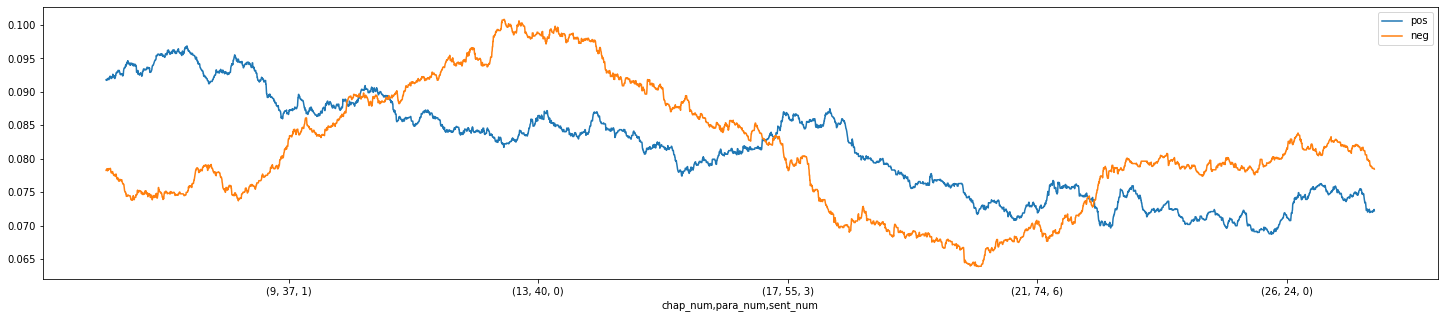

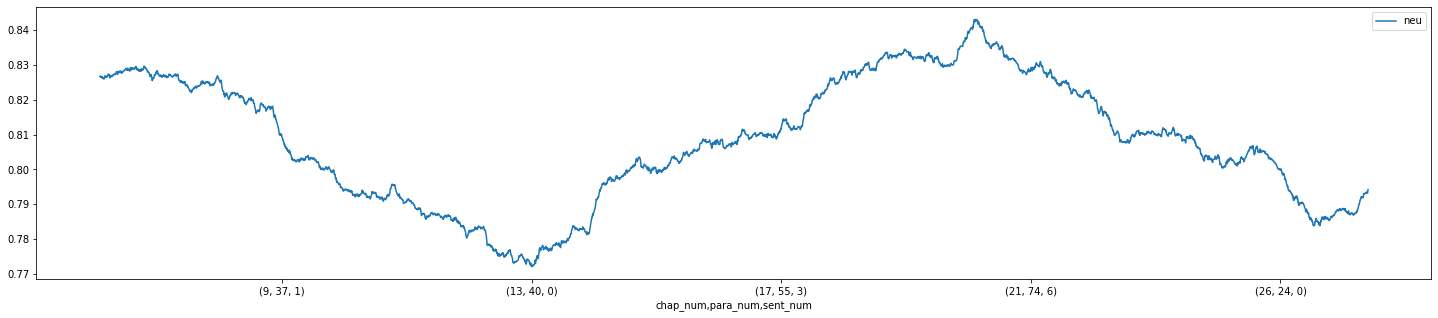

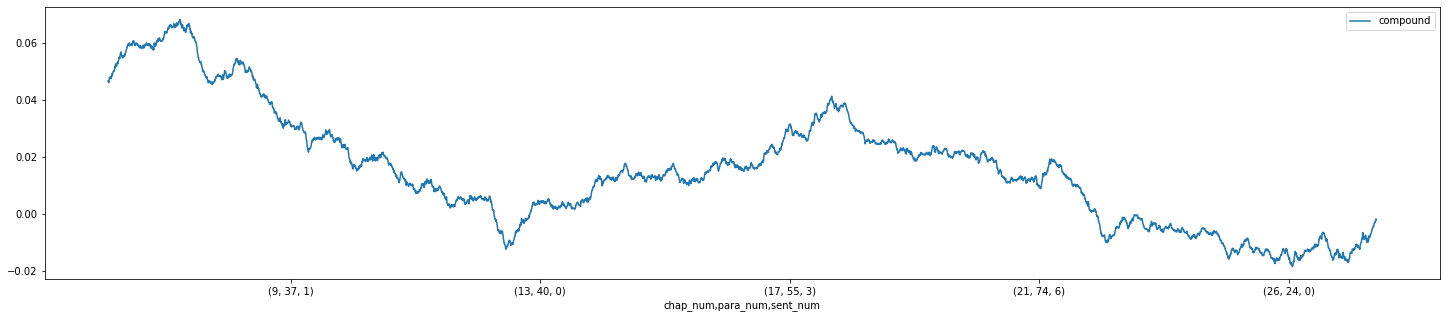

In [237]:
w = int(PHANTOM_vader.shape[0] / 5)
PHANTOM_vader[['pos','neg']].rolling(w).mean().plot(figsize=(25,5))
PHANTOM_vader[['neu']].rolling(w).mean().plot(figsize=(25,5))
PHANTOM_vader[['compound']].rolling(w).mean().plot(figsize=(25,5))

## Part 5: Present